# Bike Sharing Demand

Access competition [here](https://www.kaggle.com/c/bike-sharing-demand/)

# Exploration

**Loading**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [98]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

**First look at the data**

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


**Exploration**

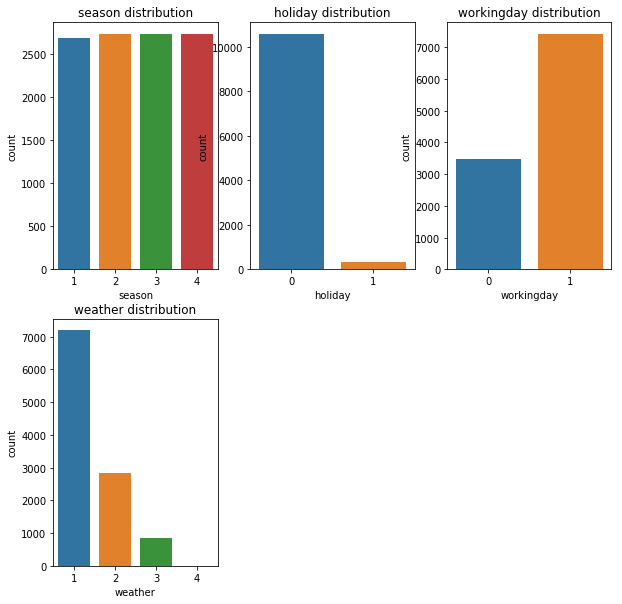

In [57]:
cat_names=['season','holiday','workingday','weather']

plt.figure(figsize=(10,10))

for i,name in enumerate(cat_names):
    plt.subplot(2,3,i+1)
    sns.countplot(name,data=train)
    plt.title(name + ' distribution')
    
plt.show()

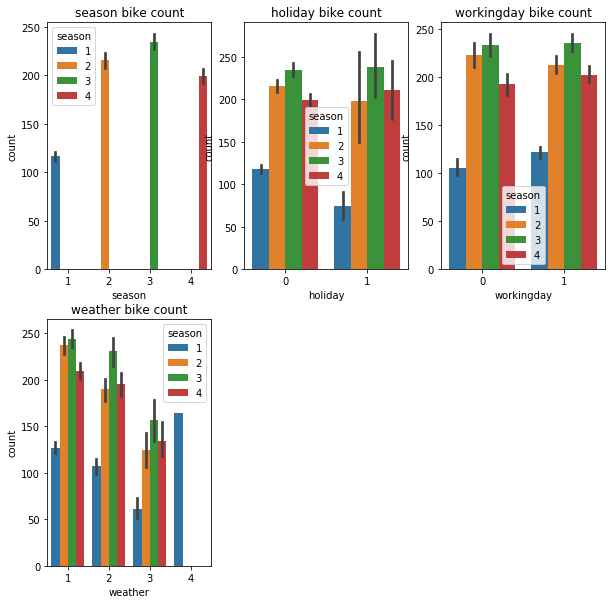

In [59]:
cat_names=['season','holiday','workingday','weather']

plt.figure(figsize=(10,10))

for i,name in enumerate(cat_names):
    plt.subplot(2,3,i+1)
    sns.barplot(y='count',x=name,hue='season',data=train)
    plt.title(name + ' bike count')
    
plt.show()

As we could have thought, season influence the number of bikes token.

**Outliers & missing data**

The data does not seem to have missing rows. Let's look at the outliers:

Variables distribution:

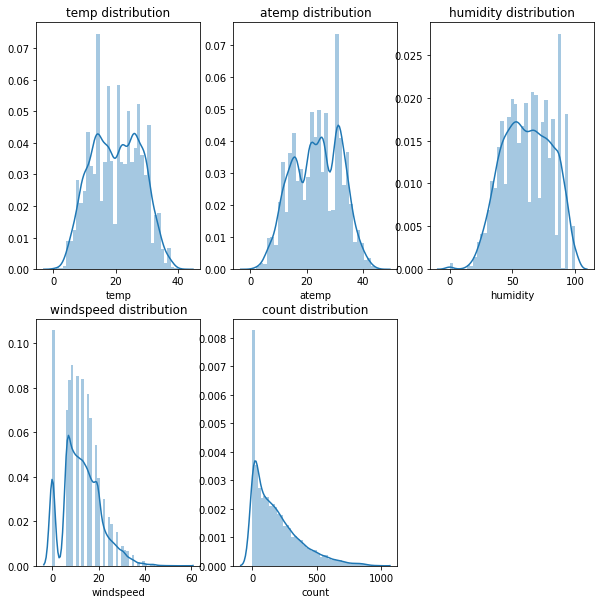

In [54]:
cat_names=['temp','atemp','humidity','windspeed','count']

plt.figure(figsize=(10,10))

for i,name in enumerate(cat_names):
    plt.subplot(2,3,i+1)
    sns.distplot(train[name])
    plt.title(name + ' distribution')
    
plt.show()

Count and windspeed seem skewed. Let's try their log,square or box-cox transformation:

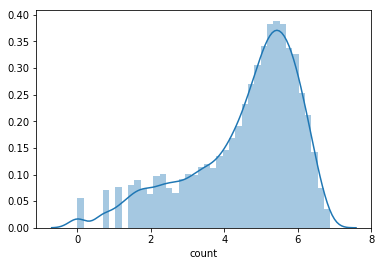

In [50]:
sns.distplot(train['count'].apply(lambda x:np.log(x)))
#sns.distplot(train['count'].apply(lambda x:np.sqrt(x))) #square root
#from scipy.stats import boxcox
#sns.distplot(boxcox(train['count'])[0]) #box-cox

((array([-3.82906622, -3.60493717, -3.48193604, ...,  3.48193604,
          3.60493717,  3.82906622]),
  array([0.        , 0.        , 0.        , ..., 6.64898455, 6.64898455,
         6.65157187])),
 (1.4131977790864998, 4.530517347292344, 0.9544327285929766))

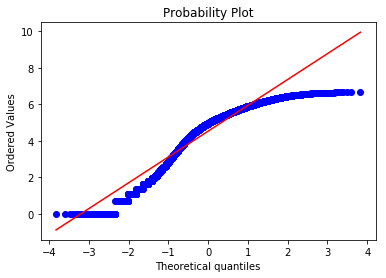

In [141]:
from scipy import stats
fig,axes = plt.subplots(ncols=1,nrows=1)
stats.probplot(train['count'], dist='norm', fit=True, plot=axes)

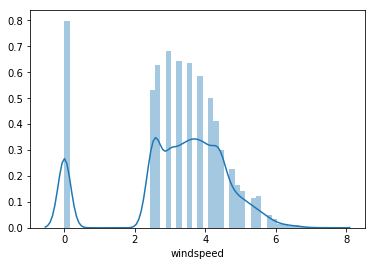

In [47]:
sns.distplot(train['windspeed'].apply(lambda x:np.sqrt(x)))

Windspeed has serious outliers. But they seem important. Let's keep them for now.

In [99]:
def distribute(train):
    train['count'] = train['count'].apply(lambda x:np.log(x))
    return train

In [100]:
train = distribute(train)

Let's look at the count distribution.

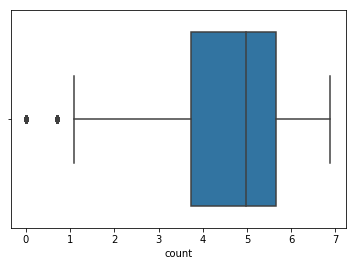

In [120]:
sns.boxplot(train['count'])

As per Chebychev's rule, 3 std. deviations account for 99% of data. Using this approach, we filter out the rest of the data.

In [126]:
def rem_outliers(train):
    q99=np.percentile(train['count'].values,[99])
    train=train[train['count']<q99[0]]
    return train

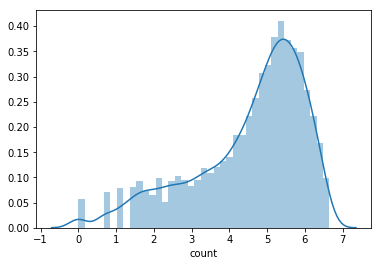

In [127]:
train = rem_outliers(train)
sns.distplot(train['count'])
plt.show()

**Feature engineering**

Let's see if there is a seasonnality:

We do a brief time-series analysis to see if there's any improvement in count over a period of time. The moving average to be calculated for a period of 3 months as we suspect a seasonnality of 3 month due to the seasons.

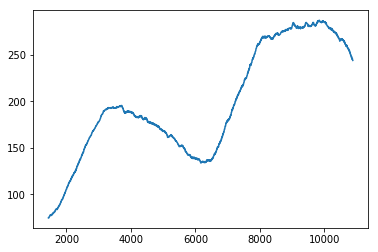

In [65]:
plt.plot(train['count'].rolling(60*24).mean())

In [101]:
def seasonnality(train):
    train['datetime']=pd.to_datetime(train['datetime'])
    train['year'] = train['datetime'].apply(lambda x:x.year)
    train['month']= train['datetime'].apply(lambda x:x.month)
    train['day']= train['datetime'].apply(lambda x:x.day)
    train['hour']= train['datetime'].apply(lambda x:x.hour)
    return train

In [102]:
train = seasonnality(train)

**Features Selection**

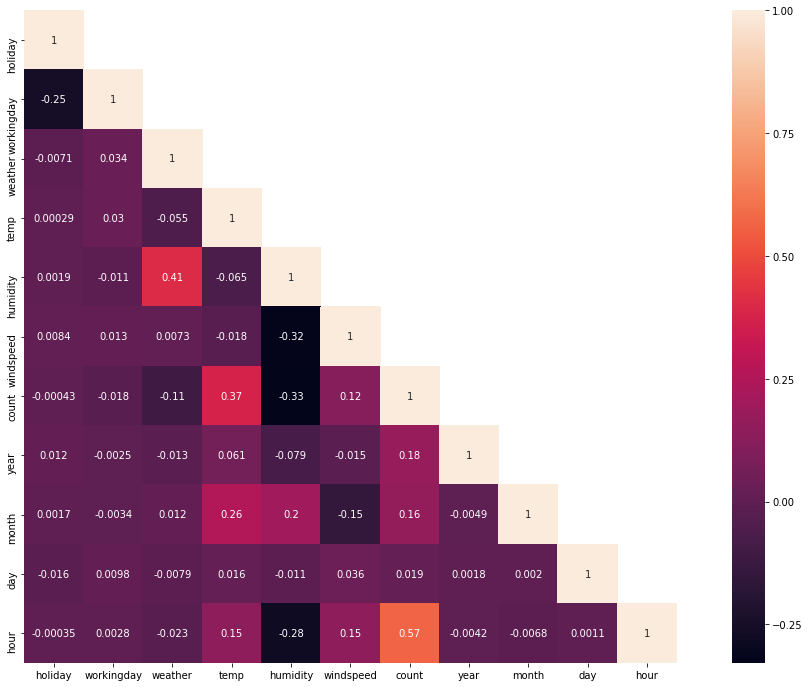

In [83]:
cor_mat= train[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(20,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

We can see a high correlation between month and season, temp and atemp, and between count and registered/casual. Let's remove those for now.

Hour have no impact, let's remove it. 

In [103]:
def drop_feat(train):
    train = train.drop(['datetime','season','atemp','registered','casual','day'],axis=1)
    return train

In [104]:
train = drop_feat(train)

**One-hot encoding**

In [113]:
def one_hot(train):
    for i in ['holiday','workingday','weather','year','month','hour']:
        train[i] = train[i].astype('category')
    train = pd.get_dummies(train)
    return train

In [114]:
train = one_hot(train)

**Data split for training**

In [118]:
def split(train):
    y = train['count']
    X = train.drop(['count'],axis=1)    
    return X,y

X,y = split(train)

In [119]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

## Modelling

In [169]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from progressbar import progressbar

models = [LinearRegression(),Lasso(),Ridge(),RandomForestRegressor(),xgb.XGBRegressor()]
models_name = ['LR','Lasso','Ridge','RandomForest','GradientBoost']
d = {}
rmse = []
score = []

for i,model in progressbar(enumerate(models)):
    clf = model
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    rmse.append(mean_squared_error(y_test,y_pred))
    score.append(clf.score(X_test,y_test))
d = {'Model':models_name,'Score':score,'RMSE':rmse}
d = pd.DataFrame(d).sort_values(by='Score',ascending=False)
d

/ |#                                                  | 0 Elapsed Time: 0:00:00/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
| |                 #                                 | 4 Elapsed Time: 0:00:01


,Model,Score,RMSE
3,RandomForest,0.929903,0.160967
4,GradientBoost,0.878090,0.279949
0,LR,0.833247,0.382926
2,Ridge,0.833128,0.383199
1,Lasso,0.218322,1.795019


Let's use RandomForest and tune it a bit. We use a 5-fold cross-validation.

In [171]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
'n_estimators': range(1,50),
'max_features': range(1,X_train.columns.size),
'max_depth': range(1,20),
'min_samples_split': range(2,20),
'min_samples_leaf':range(2,20),
}

my_forest = RandomForestRegressor()
my_forest_cv = RandomizedSearchCV(my_forest, param_dist, n_jobs=2,cv=5)
my_forest_cv = my_forest_cv.fit(X_train,y_train)

print("Score: ", my_forest_cv.score(X_test,y_test))
print("RMSE: ", mean_squared_error(y_test,my_forest_cv.predict(X_test)),'\n')
print("Best parameters: ", my_forest_cv.best_params_,'\n')

Score:  0.9093569202197581
RMSE:  0.20814957189863464 

Best parameters:  {'n_estimators': 25, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 22, 'max_depth': 18} 



Let's look at the most influent features

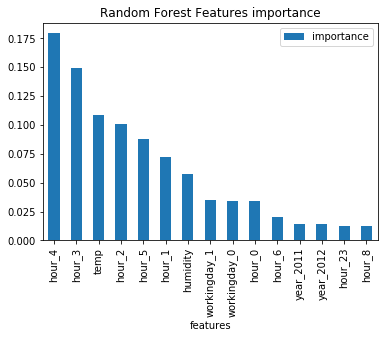

In [178]:
my_forest = my_forest_cv.best_estimator_

forest_viz = pd.DataFrame()
forest_viz['features'] = X_train.columns
forest_viz['importance'] = my_forest.feature_importances_
forest_viz = forest_viz.sort_values(by=['importance'],ascending=False)[:15]
forest_viz = forest_viz.set_index('features')
forest_viz.plot(kind='bar',title='Random Forest Features importance')

## Prediction

We can now create the pipeline and submit an answer.

In [194]:
def drop_feat_test(train):
    train = train.drop(['datetime','season','atemp','day'],axis=1)
    return train

def pipeline_train(train):
    train = distribute(train)
    train = rem_outliers(train)
    train = seasonnality(train)
    train = drop_feat(train)
    train = one_hot(train)
    X,y = split(train)
    return X,y

def pipeline_test(test):
    test = seasonnality(test)
    test = drop_feat_test(test)
    test = one_hot(test)
    X = test
    return X

In [195]:
X = pipeline_test(test)
y_pred = my_forest.predict(X)
count = [max(0, x) for x in np.exp(y_pred)]
d = {'datetime':test['datetime'],'count':count}
d = pd.DataFrame(d)
d.to_csv('answer.csv',index=False)